In [121]:
# Install dependencies
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Simulation parameters
GeV_to_J = 1.60218e-10   # [J/GeV]
c    = 299892458         # [m/s]
e    = 1.602e-19         # [C]
q    = np.array([-e, 0, 0])        # electron charge
m    = np.array([511e-6, 0, 0])    # [GeV/c^2]

tmax = 1e-10
dt   = 1e-12

# Initial parameters
t0 = 0                   # [s]

x0 = 0                   # [m]
y0 = 0                   # [m]
z0 = 0                   # [m]

px0 = 1                  # [Gev/c]
py0 = 0                  # [Gev/c]
pz0 = 0                  # [Gev/c]

E0 = np.sqrt((px0**2 + py0**2 + pz0**2)*c)


Ex = 0                      # [V/m]
Ey = 0                      # [V/m]
Ez = 0                      # [V/m]
E = np.array([Ex, Ey, Ez])

Bx = 0                   # [T]
By = 0                   # [T]
Bz = 1                   # [T]
B = np.array([Bx, By, Bz])

# Set the initial state vector and the parameters
r0 = np.array([t0, x0, y0, z0, E0, px0, py0, pz0])
par = np.array([q, m, E, B])

In [122]:
def eom(r, par):
    # Unpack the variables from the state vector
    t, x, y, z = r[0], r[1], r[2], r[3]
    En, px, py, pz = r[4], r[5], r[6], r[7]

    # Unpack parameters
    q_array, m_GeV_array, E, B = par

    q = q_array[0]
    m_GeV = m_GeV_array[0]

    m = m_GeV * GeV_to_J / c**2
    px_si = px * GeV_to_J / c
    py_si = py * GeV_to_J / c
    pz_si = pz * GeV_to_J / c

    vx = px_si / m
    vy = py_si / m
    vz = pz_si / m
    Ex, Ey, Ez = E[0], E[1], E[2]
    Bx, By, Bz = B[0], B[1], B[2]

    # Lorent force in SI units
    dpx = q * (Ex + vy * Bz - vz * By)
    dpy = q * (Ey + vz * Bx - vx * Bz)
    dpz = q * (Ez + vx * By - vy * Bx)

    # Convert the force back to GeV/c for updating momentum
    dpx_GeV = dpx / (GeV_to_J / c)
    dpy_GeV = dpy / (GeV_to_J / c)
    dpz_GeV = dpz / (GeV_to_J / c)

    # Return derivatives : [dt/dt, dx/dt, dy/dt, dz/dt, dEn/dt, dpx/dt, dpy/dt, dpz/dt]

    new_par = np.array([1, vx, vy, vz, 0, dpx_GeV, dpy_GeV, dpz_GeV])
    
    return new_par

In [123]:
# Define a function to plot eletrons trajectory
def plot_trajectory(r, xlim, ylim, savefig=False, filename=None, title=None, fontsize=18):
    # Get the x-y coordinates from the state vector
    x = r[:, 1]
    y = r[:, 2]

    # Plot them
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x, y, label="Particle's trajectory")

    # Set labels
    ax.set_xlabel("x [m]", fontsize=fontsize)
    ax.set_ylabel("y [m]", fontsize=fontsize)

    # Set tick fontsize
    ax.tick_params(labelsize=fontsize)

    # Set lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set title
    ax.set_title(title)

    plt.grid(True)
    plt.legend(loc="upper left", fontsize=fontsize)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
    plt.show()

In [132]:
# Define a function that plots the energy against time
def E_against_t(r, par=par, savefig=False, filename=None, fontsize=18):
    # Unpack the mass
    _, m, _, _ = par
    
    # Time
    t = r[:, 0]
    
    # Get the energy from the state vector (which is constant, since it is defined like that in the eom)
    En = r[:, 4]

    # Manually calculate the energy from the momenta
    px, py, pz = r[:, 5], r[:, 6], r[:, 7]
    E = np.sqrt((px**2 + py**2 + pz**2)*c)

    # Plot them
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t*1e9, En, label="Conserved energy")
    ax.plot(t*1e9, E, label="Numerically calculated energy", ls='--')

    # Set labels
    ax.set_xlabel("t [ns]", fontsize=fontsize)
    ax.set_ylabel("E [GeV]", fontsize=fontsize)

    # Set tick fontsize
    ax.tick_params(labelsize=fontsize)

    plt.grid(True)
    plt.legend(fontsize=fontsize)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
    plt.show()

In [125]:
# Euler method
def euler(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)        # Number of steps
    r = np.zeros((N, len(r0)))        # Initialization of the trajectory
    r[0] = r0                         # Initial conditions
    
    # Iterate through each time step
    for i in range(N-1):
        r[i+1] = r[i] + dt*eom(r[i], par)

    return r

# Trapezoidal method
def trapezoid(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)        # Number of steps
    r = np.zeros((N, len(r0)))        # Initialization of the trajectory
    r[0] = r0                         # Initial conditions
    
    # Iterate through each time step
    for i in range(N-1):
        r_pred = r[i] + dt*eom(r[i], par)
        r[i + 1] = r[i] + 0.5 * dt * (eom(r[i], par) + eom(r_pred, par))

    return r

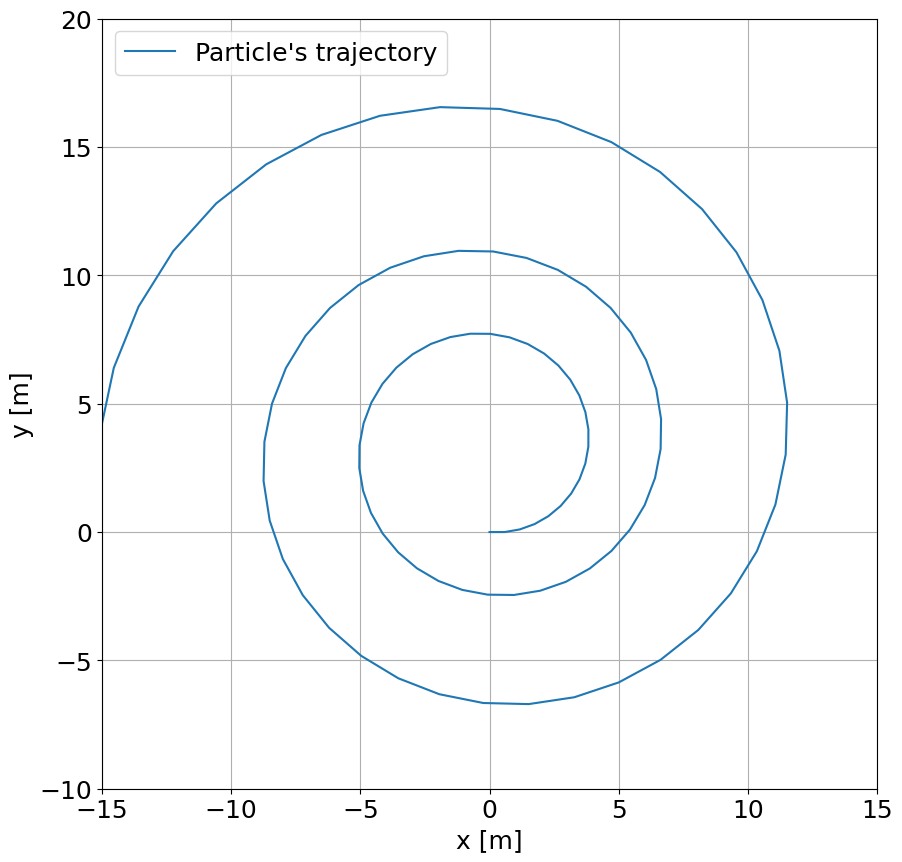

In [126]:
# calculate the electrons trajectory using Forward Euler
r_euler = euler(dt=1e-12)

# Plot the trajectory
plot_trajectory(r_euler, xlim=[-15, 15], ylim=[-10, 20], savefig=False, filename="Euler_1e-12.png")

In [127]:
# Calculate the electrons trajectory for different dt
r_euler12 = euler(dt=1e-12)
r_euler13 = euler(dt=1e-13)
r_euler14 = euler(dt=1e-14)

# Get the x-y values from the state vectors
x_euler12, y_euler12 = r_euler12[:, 1], r_euler12[:, 2]
# Plot the trajectories to evaluate convergence


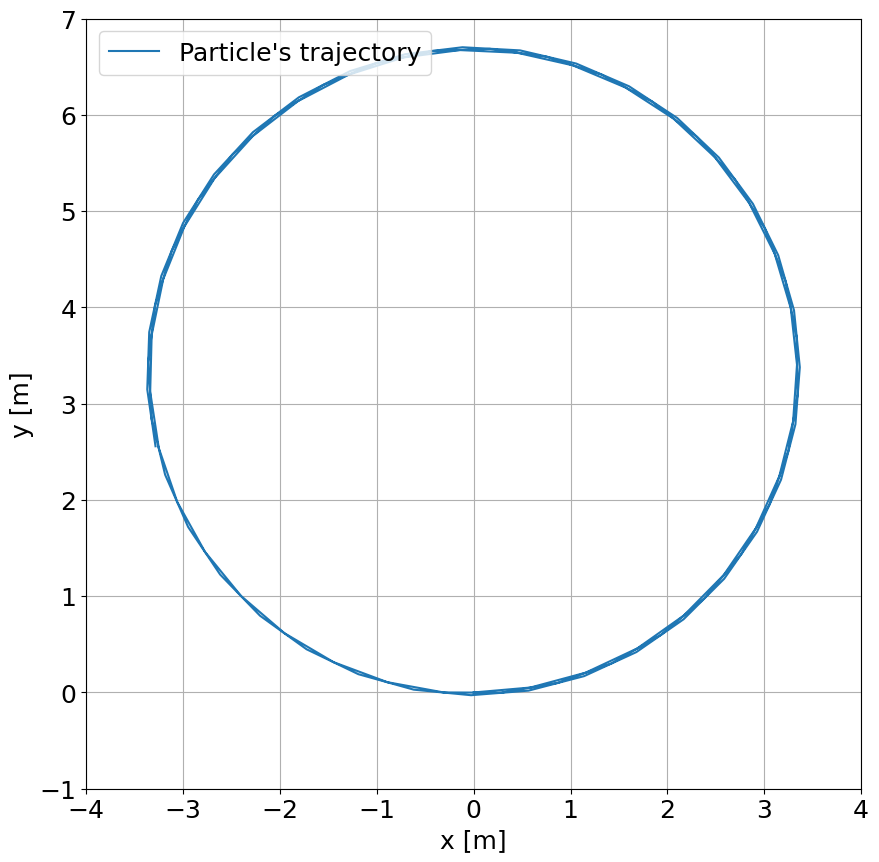

In [128]:
# calculate the electrons trajectory using Trapezoidal
r = trapezoid(dt=1e-12)

# Plot the trajectory
plot_trajectory(r, xlim=[-4, 4], ylim=[-1, 7], savefig=False, filename="Trapezoid_1e-12.png")

In [129]:
def boris_push(r, par, dt):
    # Unpack the variables from the state vector
    t, x, y, z = r[0], r[1], r[2], r[3]
    En, px, py, pz = r[4], r[5], r[6], r[7]

    # Unpack parameters
    q_array, m_GeV_array, E, B = par

    q = q_array[0]
    m_GeV = m_GeV_array[0]

    m = m_GeV * GeV_to_J / c**2
    px_si = px * GeV_to_J / c
    py_si = py * GeV_to_J / c
    pz_si = pz * GeV_to_J / c

    vx = px_si / m
    vy = py_si / m
    vz = pz_si / m
    Ex, Ey, Ez = E[0], E[1], E[2]
    Bx, By, Bz = B[0], B[1], B[2]

    # Half acceleration due to electric field
    vx_minus = vx + (q / m) * Ex * 0.5 * dt
    vy_minus = vy + (q / m) * Ey * 0.5 * dt
    vz_minus = vz + (q / m) * Ez * 0.5 * dt

    # Rotation due to magnetic field
    t_vec = (q / (2 * m)) * np.array([Bx, By, Bz]) * dt
    t_mag = np.linalg.norm(t_vec)
    s_vec = 2 * t_vec / (1 + t_mag**2)

    v_minus = np.array([vx_minus, vy_minus, vz_minus])
    v_prime = v_minus + np.cross(v_minus, t_vec)
    v_plus = v_minus + np.cross(v_prime, s_vec)

    # Half acceleration due to electric field again
    vx = v_plus[0] + (q / m) * Ex * 0.5 * dt
    vy = v_plus[1] + (q / m) * Ey * 0.5 * dt
    vz = v_plus[2] + (q / m) * Ez * 0.5 * dt

    # Update momentum in GeV/c
    px = vx * m / (GeV_to_J / c)
    py = vy * m / (GeV_to_J / c)
    pz = vz * m / (GeV_to_J / c)

    # Update position
    x += vx * dt
    y += vy * dt
    z += vz * dt

    # Return updated state vector
    return np.array([t + dt, x, y, z, En, px, py, pz])
    
def boris_method(r0=r0, par=par, tmax=tmax, dt=dt):
    N = int((tmax - r0[0])/dt)        # Number of steps
    r = np.zeros((N, len(r0)))        # State vector initialization
    r[0] = r0                         # Initial conditions
    
    # Iterate through each time step
    for i in range(N-1):
        r[i+1] = boris_push(r[i], par, dt)

    return r

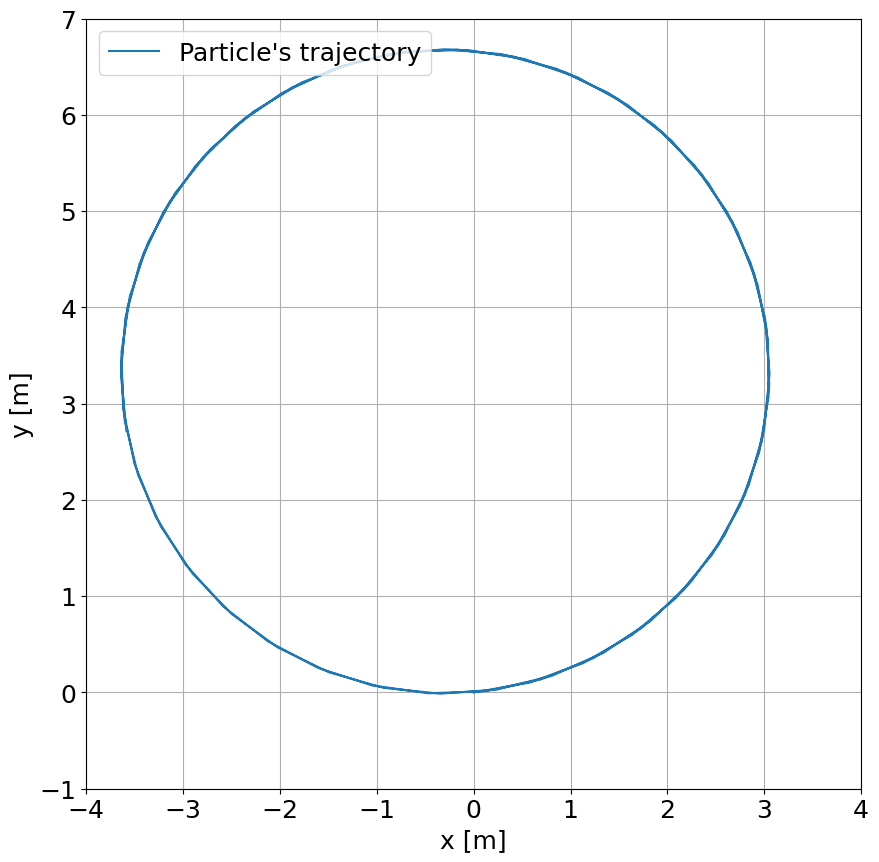

In [130]:
# Calculate the electrons trajectory using boris
r_boris = boris_method(dt=1e-12)

plot_trajectory(r_boris, xlim=[-4, 4], ylim=[-1, 7], savefig=False, filename="Boris_1e-12.png")

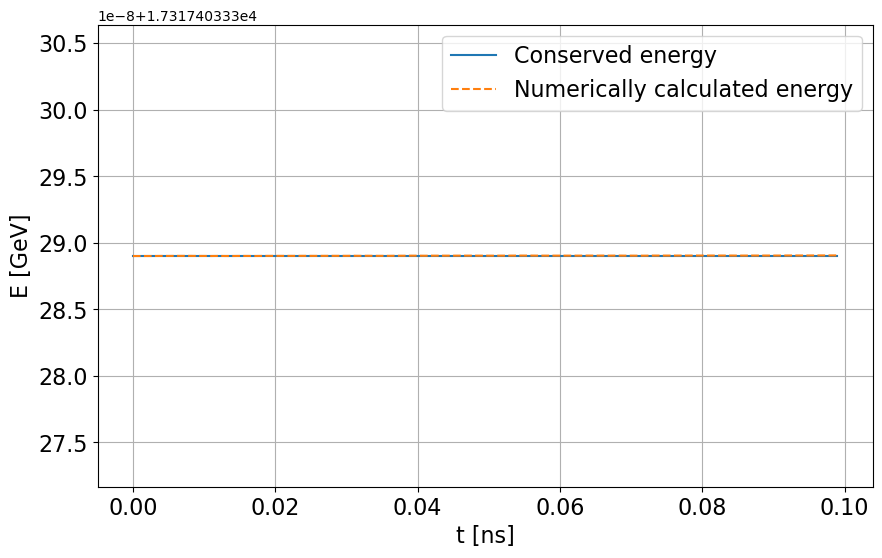

In [133]:
# Plot the energy
E_against_t(r_boris, savefig=True, fontsize=16, filename="Boris_Energy.png")

In [87]:
def calculate_radius(trajectory, num_points=100):
    """
    Calculate the radius of the trajectory by fitting a circle to sampled points.
    """
    # Sample points from the trajectory
    sampled_points = trajectory[::len(trajectory)//num_points, 1:3]

    # Function to calculate the algebraic distance between the data points and the circle
    def calc_R(xc, yc):
        return np.sqrt((sampled_points[:, 0] - xc)**2 + (sampled_points[:, 1] - yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    # Initial guess for the center (x0, y0)
    center_estimate = np.mean(sampled_points, axis=0)
    center_estimate = center_estimate.flatten()

    # Optimize the center
    center = least_squares(f_2, center_estimate).x

    # Calculate the radius as the mean distance to the center
    Ri = calc_R(*center)
    radius = Ri.mean()

    return radius, (center[0], center[1])

def larmor_radius(r, par=par):
    """
    Calculates the theoretical Larmor radius for a circular motion under a perpendicular magnetic field
    """
    # Unpack parameters
    q_array, _, _, B = par

    q  = q_array[0]
    Bz = B[2] 
    
    # Get the momenta from the state vector
    px, py = r[-1, 5], r[-1, 6]

    # Convert the momenta to SI units
    px_si = px * GeV_to_J / c
    py_si = py * GeV_to_J / c

    # Calculate the momentum perpendicular to the magnetic field
    p = np.sqrt(px_si**2 + py_si**2)
    
    return p/(abs(q)*Bz)

def error(x1, x2):
    """
    Calculates relative error
    """
    return np.abs(1 - x1/x2)

In [80]:
def convergence(method, xlim, ylim, dtc=[1e-12, 1e-13, 1e-14], savefig=False, filename=None, title=None, fontsize=18):
    if method=="Euler":
        r1 = euler(dt=dtc[0])
        r2 = euler(dt=dtc[1])
        r3 = euler(dt=dtc[2])
        
    if method=="Trapezoid":
        r1 = trapezoid(dt=dtc[0])
        r2 = trapezoid(dt=dtc[1])
        r3 = trapezoid(dt=dtc[2])
        
    if method=="Boris":
        r1 = boris_method(dt=dtc[0])
        r2 = boris_method(dt=dtc[1])
        r3 = boris_method(dt=dtc[2])

    # Calculate the experimental, theoretical radii and the relative error
    R1, _ = calculate_radius(r1)
    RL1   = larmor_radius(r1)
    E1    = error(R1, RL1)

    R2, _ = calculate_radius(r2)
    RL2   = larmor_radius(r2)
    E2    = error(R2, RL2)

    R3, _ = calculate_radius(r3)
    RL3   = larmor_radius(r3)
    E3    = error(R3, RL3)

    # Get the x-y plane position values
    x1, y1 = r1[:, 1], r1[:, 2]
    x2, y2 = r2[:, 1], r2[:, 2]
    x3, y3 = r3[:, 1], r3[:, 2]

    # Plot them
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(x1, y1, label=f"dt = {dtc[0]} \nError = {E1*100:.2}%")
    print(f"dt : {dtc[0]} \nExperimental Radius : {R1:.5f} m \nLarmor Radius : {RL1:.5f} m \n")
    ax.plot(x2, y2, label=f"dt = {dtc[1]} \nError = {E2*100:.2}%")
    print(f"dt : {dtc[1]} \nExperimental Radius : {R2:.5f} m \nLarmor Radius : {RL2:.5f} m \n")
    ax.plot(x3, y3, label=f"dt = {dtc[2]} \nError = {E3*100:.2}%")
    print(f"dt : {dtc[2]} \nExperimental Radius : {R3:.5f} m \nLarmor Radius : {RL3:.5f} m \n")

    # Set labels
    ax.set_xlabel("x [m]", fontsize=fontsize)
    ax.set_ylabel("y [m]", fontsize=fontsize)

    # Set tick fontsize
    ax.tick_params(labelsize=fontsize)

    # Set lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set title
    ax.set_title(title)

    plt.grid(True)
    plt.legend(loc="upper left", fontsize=fontsize)

    # Save the figure
    if savefig:
        plt.savefig(filename)
        
    plt.show()

dt : 1e-12 
Experimental Radius : 3.34779 m 
Larmor Radius : 3.33490 m 

dt : 1e-13 
Experimental Radius : 3.33503 m 
Larmor Radius : 3.33490 m 

dt : 1e-14 
Experimental Radius : 3.33490 m 
Larmor Radius : 3.33490 m 



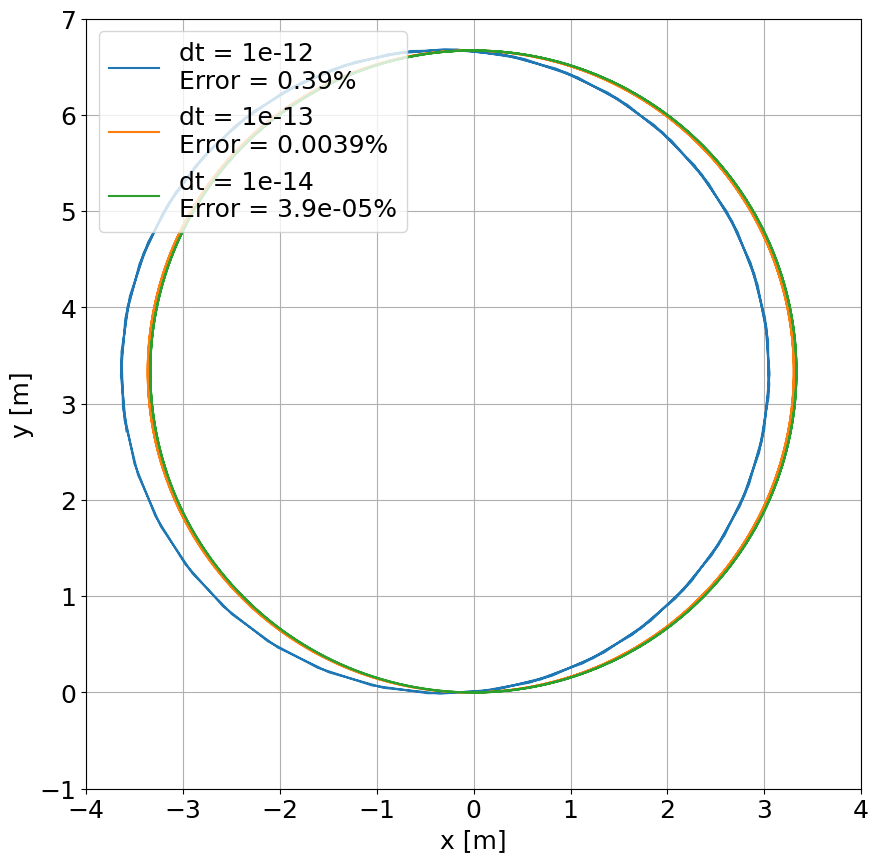

In [81]:
convergence("Boris", xlim=[-4, 4], ylim=[-1, 7])

MovieWriter Pillow unavailable; using Pillow instead.
C:\Users\Asus\AppData\Local\Temp\ipykernel_40612\748365128.py:29: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  electron_plot.set_data(x_electron, y_electron)
C:\Users\Asus\AppData\Local\Temp\ipykernel_40612\748365128.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  proton_plot.set_data(x_proton, y_proton)


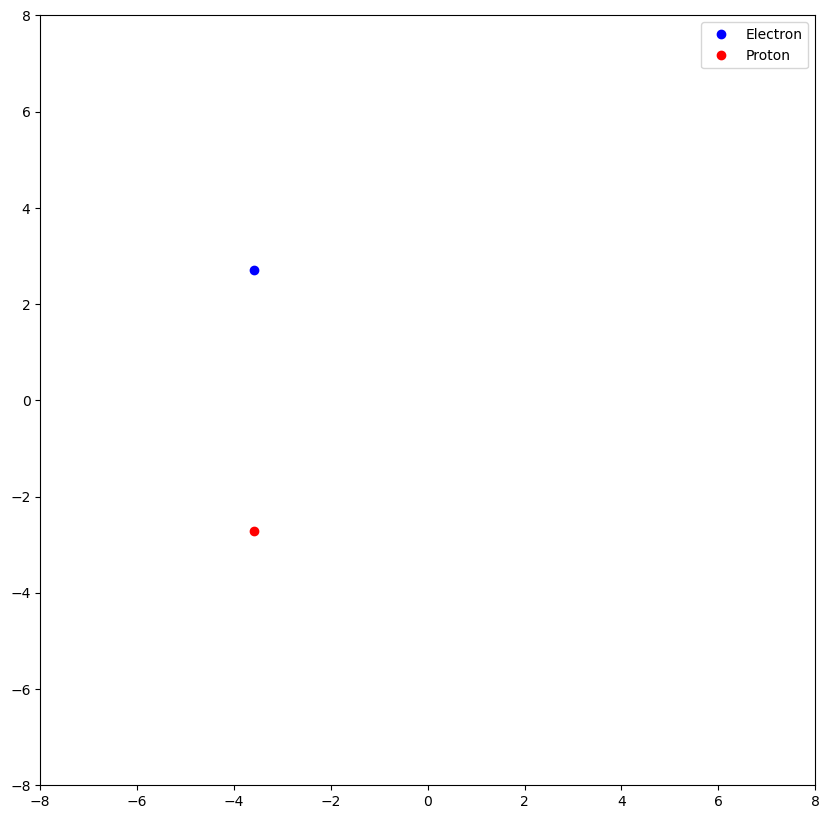

In [100]:
# Initial conditions for electron
r0_electron = r0
par_electron = par

# Initial conditions for proton
r0_proton = r0
par_proton = np.array([-q, m, E, B])

# Generate trajectories using Boris method
trajectory_electron = boris_method(r0_electron, par_electron, tmax, dt)
trajectory_proton = boris_method(r0_proton, par_proton, tmax, dt)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

electron_plot, = ax.plot([], [], 'bo', label='Electron')
proton_plot, = ax.plot([], [], 'ro', label='Proton')

def init():
    electron_plot.set_data([], [])
    proton_plot.set_data([], [])
    return electron_plot, proton_plot

def update(frame):
    x_electron = trajectory_electron[frame, 1]
    y_electron = trajectory_electron[frame, 2]
    electron_plot.set_data(x_electron, y_electron)
    
    x_proton = trajectory_proton[frame, 1]
    y_proton = trajectory_proton[frame, 2]
    proton_plot.set_data(x_proton, y_proton)
    
    return electron_plot, proton_plot

# Create the animation
ani = FuncAnimation(fig, update, frames=len(trajectory_electron), init_func=init, blit=True)

# Save the animation as a GIF
ani.save('Boris_push_two_particles_noE.gif', writer='Pillow', fps=10)

# Show the animation
plt.legend()
plt.show()